# NMF – Wine Quality (Vin rouge)

Ce notebook applique **NMF (Non-negative Matrix Factorization)** selon le cahier des charges :
- Identifier des composants chimiques dominants
- Utiliser des features positives
- Visualisation 2D
- Suivi avec MLflow

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Trouver la racine du projet (dossier contenant src/preprocessing.py)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project (File > Open Folder) puis relancez.")
from preprocessing import load_data, clean_data
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF
import mlflow
import mlflow.sklearn

mlflow.set_experiment("wine-quality-nmf")

2026/02/14 17:31:14 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/14 17:31:14 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/14 17:31:14 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/14 17:31:14 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/14 17:31:14 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/14 17:31:14 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/14 17:31:15 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 17:31:15 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/reduction/mlruns/3', creation_time=1770927757110, experiment_id='3', last_update_time=1770927757110, lifecycle_stage='active', name='wine-quality-nmf', tags={}>

## 2. Chargement et preprocessing

In [2]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

X = df.drop(columns=["quality"])
y = df["quality"]

# Mise à l'échelle positive (MinMaxScaler pour NMF)
mm_scaler = MinMaxScaler()
X_pos = mm_scaler.fit_transform(X)

print(f"Dataset shape: {df.shape}")
print(f"Features positives (min={X_pos.min():.3f}, max={X_pos.max():.3f})")

Dataset shape: (1359, 12)
Features positives (min=0.000, max=1.000)


## 3. Application NMF

In [3]:
# NMF 2 composantes
n_components = 2
nmf = NMF(n_components=n_components, random_state=42)
X_nmf = nmf.fit_transform(X_pos)

# Reconstruction error
reconstruction_error = nmf.reconstruction_err_
print(f"NMF embedding shape: {X_nmf.shape}")
print(f"Reconstruction error: {reconstruction_error:.3f}")

NMF embedding shape: (1359, 2)
Reconstruction error: 12.616


## 4. Visualisation 2D

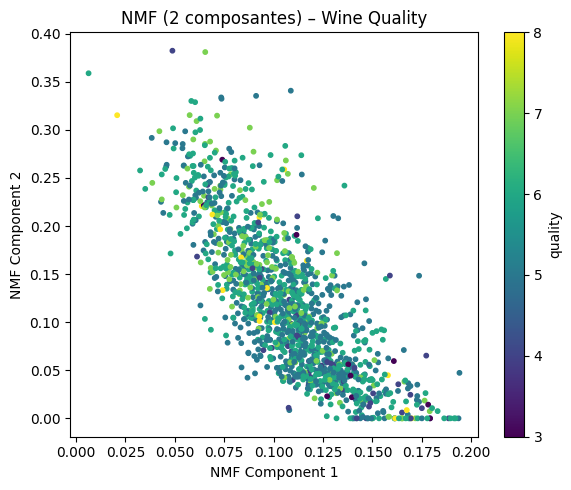

In [4]:
# Visualisation 2D colorée par quality
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_nmf[:, 0], X_nmf[:, 1], c=y, cmap="viridis", s=10)
plt.colorbar(scatter, label="quality")
plt.title("NMF (2 composantes) – Wine Quality")
plt.xlabel("NMF Component 1")
plt.ylabel("NMF Component 2")
plt.tight_layout()
plt.savefig("nmf_2d.png")
plt.show()

## 5. MLflow tracking

In [5]:
with mlflow.start_run(run_name="NMF_2components"):
    mlflow.log_param("n_components", n_components)
    mlflow.log_param("random_state", 42)
    mlflow.log_metric("reconstruction_error", float(reconstruction_error))
    mlflow.log_artifact("nmf_2d.png")
    mlflow.sklearn.log_model(nmf, "nmf_model")
    print("MLflow run terminé")

2026/02/14 17:31:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
2026/02/14 17:31:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


MLflow run terminé
